In [7]:
import tensorflow as tf

# 데이터 불러오기

In [112]:
import glob
import os

# txt_file_path = os.getenv('HOME')+'./aiffel/lyricist/data/lyrics/*'
txt_file_path = './data/lyrics/*'
txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
# print("Examples:\n", raw_corpus[:100])

데이터 크기: 187088


In [73]:
# raw_corpus[:1000]

# 문장 전처리
## 1. 입력된 문장을 정규표현식을 이용해 정제함
  1. 소문자로 바꾸고, 양쪽 공백을 지움
  2. [] 안에 있는 단어는 코러스 등 지시문이므로 삭제
    - ()안에 있는 단어는 가사이므로 보존
  2. 특수문자?.! 양쪽에 공백
  3. '는 's소유 't부정의 의미가 있으므로 제외하지 않음
    - gon' 등 축약형의 '는 여전히 그 자리에 있음
    - [Trouble] 기존에 '를 동일하게 취급해서 처리했더니 '다음 아무것도 없는 경우 발생
      - 이 경우 의미가 있는 's와 't만 처리하여 예외 처리함
  4. 여러개의 공백은 하나의 공백으로 바꿉니다
  5. a-zA-Z?.!,'가 아닌 모든 문자를 하나의 공백으로 바꿉니다
  6. 다시 양쪽 공백을 지웁니다
  7. 문장 시작에는 \<start>, 끝에는 \<end>를 추가합니다
  
  - [Trouble] 정규표현식 사용법 : 해결하지 못함
    - 중복된 단어는 하나로 합치고 싶다!
    - 1글자로 이루어진 단어(d, k, l 등)는 제외하고 싶다!


<!--   8. 중복된 단어는 하나로 합쳐버리고 싶어 -->


In [113]:
def preprocess_sentence(sentence):
    import re
    sentence = sentence.lower().strip() #1
    sentence = re.sub(r"(\[.*\])", '', sentence) #2
    sentence = re.sub(r"([?.!])", r" \1 ", sentence) # 3
    sentence = re.sub(r"('[s|t])", r" \1", sentence) # 4
    sentence = re.sub(r'[" "]+', " ", sentence) # 5
    sentence = re.sub(r"[^a-zA-Z?.!']+", " ", sentence) # 6
    sentence = re.sub(r'[" "]+', " ", sentence) #5
    sentence = sentence.strip() # 7
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("he's a ;;;sample        sentence."))

<start> he 's a sample sentence . <end>


## 2. preprocess_sentence로 정제한 문장을 모음
  - 이때, 아무것도 들어 있지 않은 문장은 제외
  - 정제 후 토큰의 개수 4개 이상 15개 이하(단어의 개수 2개 이상 13개 이하) 인 것만 남김
    - 단어의 개수가 1개인 경우 문장 형성에 불필요한 정보가 될 것으로 추정
    - \<start\> hello \<end\> ⇒ **input**: hello **output**: \<end\>
  - ~~정제 후 중복된 문장은 제외~~
    - 중복된 문장을 제외할 경우 문장의 갯수가 줄어들어 train이 제대로 이루어지지 않음

In [114]:
corpus = []
for idx, sentence in enumerate(raw_corpus):
    # 아무것도 들어 있지 않은 문장 제외
    if len(sentence) == 0 : continue
    
    preprocessed_sentence = preprocess_sentence(sentence)
    # 정제후 단어의 개수가 13개를 넘는 문장 제외
    if not ( preprocessed_sentence.count(' ')+1 <= 15) : continue
    # 정제후 단어의 개수가 1개인 문장 제외
    if preprocessed_sentence.count(' ')+1 <= 4 : continue
    # 정제하고 나니 corpus에 이미 등록되어 있는 경우는 건너뜀
    # if preprocessed_sentence in corpus : continue
    corpus.append(preprocessed_sentence)

## 3. 텐서플로우 활용을 위한 토큰화
 - tensorflow.Tokenizer, tensorflow.pad_sequences를 이용
 - 단어의 개수 12000

In [115]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus로 tokenizer 내부의 단어장을 완성
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게함
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen = 15)  
    print(tensor,tokenizer)
    return tensor, tokenizer

In [116]:
tensor, tokenizer = tokenize(corpus)

tensor.shape

[[  2   5 185 ...   0   0   0]
 [  2   9 584 ...   0   0   0]
 [  2  51  37 ...   0   0   0]
 ...
 [  2   5  88 ...   0   0   0]
 [  2   8 154 ...   0   0   0]
 [  2 175  15 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x7fc9c22d4a90>


(153524, 15)

In [46]:
# for idx in tokenizer.index_word:
#     print(idx, ":", tokenizer.index_word[idx])
#     if idx >= 10: break
        
# print(tokenizer.num_words)

# 4. 텐서플로우 활용을 위한: data 분리 

In [117]:
from sklearn.model_selection import train_test_split

src_input = tensor[:, :-1]
tgt_input = tensor[:, 1:]  

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size = 0.2, random_state = 2)
enc_val_train, enc_val_val, dec_val_train, dec_val_val = train_test_split(enc_train, dec_train, test_size = 0.125 , random_state = 2) 
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (122819, 14)
Target Train: (122819, 14)


 - Dataset을 제외하고 val_loss가 급격히 감소하는 것을 볼 수 있었다.
   - [Trouble] 왜 Dataset의 제외가 성능증가를 부르는가? 이유를 모름.

In [ ]:
BUFFER_SIZE = len(enc_val_train) #텐서의 1차원, 전체 문장의 개수
BATCH_SIZE = 128        #문장의 개수
steps_per_epoch = BUFFER_SIZE // BATCH_SIZE

# tokenizer가 구축한 단어사전 내 12000개 + 0:<pad>를 포함
VOCAB_SIZE = tokenizer.num_words + 1

dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset = tf.data.Dataset.from_tensor_slices((enc_val_train, dec_val_train))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

# 모델 정의 및 학습

## 1. 모델 구조 정의

In [119]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
#         out = self.lstm(out)
#         out = self.lstm2(out)
        out = self.linear(out)
        
        return out
 

- 하이퍼 파라미터 지정과 모델 생성
  - embedding_size를 256으로 올려 고려하는 feature의 수를 늘림
  - hidden_size를 2048로 올려 각 레이어의 노드 수를 늘림

## 2. 모델 생성

In [120]:
embedding_size = 256 #단어 하나의 특징 수
hidden_size = 2048 #퍼셉트론의 개수
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

- 생성된 모델 살펴보기: model_summary
  - 하나의 배치만 이용하면 임시 모델을 생성해볼 수 있다

In [121]:
for src_sample, tgt_sample in dataset.take(1): break

In [122]:
model(src_sample)

<tf.Tensor: shape=(128, 14, 12001), dtype=float32, numpy=
array([[[ 8.34989769e-05,  2.43568022e-04,  1.79514129e-04, ...,
         -1.91331055e-04, -7.05592247e-05,  9.13384138e-05],
        [ 1.17490621e-04,  2.14526808e-04,  5.07955847e-04, ...,
         -3.37894016e-04, -4.24497921e-05,  1.95993198e-04],
        [ 3.12292075e-04, -9.21216488e-05,  6.10091141e-04, ...,
         -3.50844668e-04,  4.59564835e-05,  2.17885696e-04],
        ...,
        [ 5.13698673e-04, -1.33104774e-03,  8.53621576e-04, ...,
         -5.36694824e-05,  8.95319972e-05,  7.88317586e-04],
        [ 4.92971798e-04, -9.85668856e-04,  8.03068222e-04, ...,
          2.02981479e-04,  1.77596503e-05,  7.09065178e-04],
        [ 4.06886858e-04, -8.43359740e-04,  9.38313548e-04, ...,
          1.28064989e-04, -1.85744721e-05,  8.42629233e-04]],

       [[ 8.34989769e-05,  2.43568022e-04,  1.79514129e-04, ...,
         -1.91331055e-04, -7.05592247e-05,  9.13384138e-05],
        [ 1.91379557e-04,  4.46302351e-04,  5

In [123]:
model.summary()

Model: "text_generator_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      multiple                  3072256   
_________________________________________________________________
lstm_12 (LSTM)               multiple                  18882560  
_________________________________________________________________
lstm_13 (LSTM)               multiple                  33562624  
_________________________________________________________________
dense_6 (Dense)              multiple                  24590049  
Total params: 80,107,489
Trainable params: 80,107,489
Non-trainable params: 0
_________________________________________________________________


- optimizer와 loss function 지정
  - optimizer: SGD를 사용해보았으나 Adam이 더 성능이 좋음

In [124]:
optimizer = tf.keras.optimizers.Adam()
# optimizer = tf.keras.optimizers.SGD()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [125]:
model.compile(loss=loss, optimizer=optimizer)

- checkpoint 설정: ModelCheckpoint

In [126]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

## 3. 모델 학습: fit

In [89]:
# model.fit(x = enc_train, y = dec_train, epochs=10, batch_size=128, validation_data = (enc_val_val, dec_val_val)
#          , callbacks =[checkpoint_callback])

model.fit(x = enc_train, y = dec_train, epochs=10, batch_size=128, validation_data = (enc_val_val, dec_val_val)
         , callbacks =[checkpoint_callback])

Epoch 1/10
951/951 [==============================] - 472s 493ms/step - loss: 3.7320 - val_loss: 2.9184
Epoch 2/10
951/951 [==============================] - 472s 496ms/step - loss: 2.8824 - val_loss: 2.5730
Epoch 3/10
951/951 [==============================] - 473s 497ms/step - loss: 2.5669 - val_loss: 2.2502
Epoch 4/10
951/951 [==============================] - 473s 497ms/step - loss: 2.2492 - val_loss: 1.9525
Epoch 5/10
951/951 [==============================] - 472s 496ms/step - loss: 1.9617 - val_loss: 1.6775
Epoch 6/10
951/951 [==============================] - 471s 495ms/step - loss: 1.6926 - val_loss: 1.4511
Epoch 7/10
951/951 [==============================] - 472s 496ms/step - loss: 1.4704 - val_loss: 1.2701
Epoch 8/10
951/951 [==============================] - 472s 496ms/step - loss: 1.2867 - val_loss: 1.1328
Epoch 9/10
951/951 [==============================] - 471s 495ms/step - loss: 1.1560 - val_loss: 1.0423
Epoch 10/10
951/951 [==============================] - 472s 496m

## 4. loss 시각화

- fit결과 객체를 저장하지 않아 다시 학습을 수행했다!

In [127]:
history = model.fit(x = enc_train, y = dec_train, epochs=10, batch_size=128, validation_data = (enc_val_val, dec_val_val)
         , callbacks =[checkpoint_callback])

Epoch 1/10
960/960 [==============================] - 476s 494ms/step - loss: 3.6645 - val_loss: 2.8184
Epoch 2/10
960/960 [==============================] - 478s 498ms/step - loss: 2.7480 - val_loss: 2.3379
Epoch 3/10
960/960 [==============================] - 479s 499ms/step - loss: 2.2945 - val_loss: 1.9051
Epoch 4/10
960/960 [==============================] - 478s 498ms/step - loss: 1.9001 - val_loss: 1.5718
Epoch 5/10
960/960 [==============================] - 478s 498ms/step - loss: 1.5737 - val_loss: 1.3304
Epoch 6/10
960/960 [==============================] - 478s 498ms/step - loss: 1.3410 - val_loss: 1.1624
Epoch 7/10
960/960 [==============================] - 478s 498ms/step - loss: 1.1818 - val_loss: 1.0617
Epoch 8/10
960/960 [==============================] - 478s 498ms/step - loss: 1.0862 - val_loss: 1.0072
Epoch 9/10
960/960 [==============================] - 477s 497ms/step - loss: 1.0361 - val_loss: 0.9791
Epoch 10/10
960/960 [==============================] - 478s 498m

- 그래프
  - validation loss가 미분계수가 0이되는 Optimal한 지점을 넘어서지 않았음을 알 수 있다

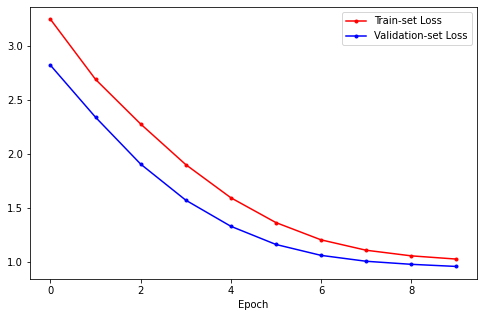

In [129]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.plot(history.history['loss'], marker='.', c='red', label='Train-set Loss')
plt.plot(history.history['val_loss'], marker='.', c='blue', label='Validation-set Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# 문장생성

In [90]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=15):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [148]:
keywords = ['love', 'my love', 'I', 'you', 'she', 'he', 'hello', 'happy', 'you must']
for start in keywords:
    print(generate_text(model, tokenizer, init_sentence= ' '.join(["<start>", start])))

<start> love is a losing hand <end> 
<start> my love is like a gunshot <end> 
<start> i know that love'll lead us <end> 
<start> you know i know that you know i know <end> 
<start> she 's got me runnin' round and round <end> 
<start> he 's constantly <unk> <unk> the british henchmen <end> 
<start> hello hello hello with the lights out it 's less dangerous <end> 
<start> happy birthday happy birthday happy birthday woo shake ! <end> 
<start> you must be out of your mind <end> 


# 회고
- 노드 진행 당시 기준 심층학습에 대한 심도 있는 이해가 없어 하이퍼 파라미터와 구조를 수정하는데 막연함에 따른 어려움을 겪었다. 한치 앞도 모르면서 하이퍼 파라미터만 바꾸는데에 주말 대부분을 할애하였으나 뚜렷한 증가를 겪지 못해 좌절감을 느꼈다. 다만, 주변의 훌륭한 분들의 도움으로 최종적으로 좋은 결과를 낼 수 있어 무척이나 감사하고 뿌듯한 일이었다.
- 프로젝트를 진행하는 동안 심층학습에 대한 공부를 병행하여 각 데이터와 가중치가 어떤식으로 관계를 맺는지 이해할 수 있었다.
- 또한 내부적으로 정규표현식, tensorflow API의 활용법에 대한 이해를 증진할 수 있었다.
- 그러나 여전히 정규표현식을 통해 원하는 문자를 나타내지 못하는 경우가 많고, Dataset을 이용하지 않을 경우 성능이 더 좋아지는 이유를 알 수 없었다.
- 결론적으로 루브릭 지표를 맞추기 위해 간략한 전처리, embedding size, hidden size, Dataset 제외 등의 조작을 하였으나 그 과정에서 중복된 단어/문장 제외, batch_size, embbedding size, hidden size를 무작위에 가깝게 조정하는 시도가 있었다.
- 심층학습에 대한 공부는 다행히도 할 수록 단순하게 이해되는 부분이 있다. 미루지 않고 꾸준히 심층학습 공부를 병행할 것을 다짐한다.